In [1]:
# Workaround to use src modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Library imports
import imageio
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.color import rgb2lab
from scipy.stats import mode

# Functions Imports
from src.utils import image_to_grayscale, image_minmax_norm
from src.quantization import image_bitshift
from src.segmentation import threshold_segmentation, otsu_segmentation
from src.visualizations import visualize_bitshift_images

#flood
from skimage.morphology import flood

#flood fill
from skimage.morphology import flood_fill

## Objetivo

Explorar técnicas de extração de paleta de cores para redução da quantidade de cores necessárias na imagem final para um N pré-selecionado.

## 1º Método - Utilizando Kmeans clustering

O primeiro método utiliza o algoritmo de aprendizado não supervisionado para gerar uma paleta de K cores que melhor representam o conjunto de cores da imagem. P/ isso utilizamos o algoritmo nas cores em diferentes espaços para verificar em qual deles as cores são melhores separáveis (RGB, LAB, HSV) além de aplicar métodos de correção gamma. 

In [3]:
from sklearn.cluster import KMeans
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter

def palette_kmeans(image, N):
    # Pré-proccess: precisamos mudar a imagem de (N,N,3) p/ (N²,3)
    image_inline =  image.reshape(-1,3)
    
    # Training the model
    kmeans = KMeans(n_clusters=N, max_iter=300)
    kmeans.fit(image_inline)
    
    # Return Collor pallete (np.array)
    palette = kmeans.cluster_centers_
    
    # Reconstruct the image with the N colors
    image_labels = kmeans.predict(image_inline)
    image_labels = image_labels.reshape((image.shape[0], image.shape[1]))
    image_output = np.zeros(image.shape)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image_output[i,j,:] = palette[image_labels[i,j]]
    
    return palette, image_output, image_labels, kmeans

def labels_to_edges(labels):
    # Pre-proccess: add symetric pad to avoid corners bugs
    edge_map = np.zeros(labels.shape, dtype=int)
    labels   = np.pad(labels, 1, mode="symmetric")
    
    # Apply Laplacian filter to detect if any 8-neighboor is diff
    # not edge -> 0 (black)
    # edge     -> 1 (white)
    for i in range(1,labels.shape[0]-1):
        for j in range(1,labels.shape[1]-1):
            same_color = np.sum(labels[i-1:i+2,j-1:j+2] == labels[i,j]) != 9
            # print(i,j,same_color)
            # print(labels[i-1:i+2,j-1:j+2])
            edge_map[i-1, j-1] = same_color * 1
    
    return edge_map

In [4]:
def plot_pallete(palette, shape):
    plt.figure(figsize=(12,1))
    for i in range(palette.shape[0]):
        plt.subplot(shape[0],shape[1],i+1)
        plt.axis("off")
        plt.imshow(np.ones((3,3,3), dtype=int)*palette[i].astype(int))
        
def plot_imagegrid(images, shape, figsize=(40,40)):
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(shape[0],shape[1],i+1)
        plt.imshow(images[i].astype(int), cmap="gray")

In [ ]:
def kill_the_bitch(aux, vet, i):
    x = vet[i][0]
    y = vet[i][1]
    
    new_color = -1
    # esquerda -> diminuindo o y
    while (new_color == -1 and y != 0):
        if aux[x][y-1][0] != i:
            #achou cor nova!!!
            new_color = aux[x][y-1][0]
        else:
            y -= 1
            
    # direita -> aumentando o y
    while (new_color == -1 and y < aux.shape[1]):
        if aux[x][y+1][0] != i:
            #achou cor nova!!!
            new_color = aux[x][y+1][0]
            #TODO: verificar se a nova cor tbm deve ser eliminada
        else:
            y += 1
    
    #atualizar matriz
    aux[aux == (i,-1,-1)] = (new_color,-1,-1)
    
    #atualizar area
    vet[new_color][2] += vet[i][2]
    vet[i][2] = 0
    
    return aux, vet
    

In [5]:
#flood
#flood(image, seed_point)
#image: An n-dimensional array.
#seed_point: The point in image used as the starting point for the flood fill.
#return:
#mask: A Boolean array with the same shape as image is returned
#with True values for areas connected to and equal (or within tolerance of) the seed point
#All other values are False.
    
#flood fill
#flood_fill(image, seed_point, new_value)
#image: An n-dimensional array
#seed_point: The point in image used as the starting point for the flood fill
#new_value: New value to set the entire fill
#Return: An array with the same shape as image is returned
#with values in areas connected to and equal (or within tolerance of) the seed point replaced with new_value


def image_flood_fill(image):
    
    # matriz auxiliar das dimensoes da imagem
    aux = image.astype(np.int32)
    

    vet = []
    # oq tem no vet?
    # (x, y) - inicio da regiao
    # area
    
    color = 0
    # encontra posição para chamar o flood fill
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if aux[x][y][1] != -1 and aux[x][y][2] != -1:
                aux = flood_fill(aux, (x, y), (color,-1,-1))
                
                #contar quantos tem na regiao
                area = np.sum(aux == (color,-1,-1))
                
                #armazena informações sobre a regiao em vet
                
                list_info = [x, y, area]
                vet.append(list_info)
                
                #incrementa o label da regiao
                color += 1
                
    #apagar regiões
    threshold = 20
    
    for i in vet:
        if vet[i][2] < threshold:
            aux, vet = kill_the_bitch(aux, vet, i)
            
            
    #atualizar aux com cores R,G,B
    for i in vet:
        if vet[i][2] != 0:
            aux[aux == (i,-1,-1)] = image[vet[i][0], vet[i][1]]
            
    return aux

In [6]:
def exploratory_pipeline(image_path, N=8, palette_shape=(2,8), save_path=None):
    
    # Obs: Em imagens png ignorar o alpha usando image[:,:,:3]
    image = imageio.imread(image_path).astype(np.uint8)
    
    # Pipeline 1 - No Image Pre-proccess 
    # - Quantization to pallete with N  colors
    # - Edge detection based on image labes
    palette, image_kmean, labels, model = palette_kmeans(image[:,:,:3], N) # Obs: pode levar até 1 min :P
    edges = labels_to_edges(labels)
    
    plot_pallete(palette, palette_shape)
    plot_imagegrid([image, image_kmean, edges], shape=(1,3), figsize=(40,40))
    
    # Pipeline 2 - Image enhance before quantize
    image_smooth = np.zeros(image[:,:,:3].shape)
    for c in range(3):
        image_smooth[:,:,c] = gaussian_filter(image[:,:,c], sigma=2, mode='nearest')
    palette, image_kmean, labels, model = palette_kmeans(image_smooth[:,:,:3], N) # Obs: pode levar até 1 min :P
    edges = labels_to_edges(labels)
    
    plot_pallete(palette, palette_shape)
    plot_imagegrid([image, image_kmean, edges], shape=(1,3), figsize=(40,40))
    
    if save_path is not None:
        imageio.imwrite(save_path, image_kmean)
        
    return image_kmean

In [7]:
a = imageio.imread('../images/raw/anime_girl.png').astype(np.uint8)[:,:,:3]
# a[:,:,0] = gaussian_filter(a[:,:,0], sigma=2, mode='nearest')
# a[:,:,1] = gaussian_filter(a[:,:,1], sigma=2, mode='nearest')
# a[:,:,2] = gaussian_filter(a[:,:,2], sigma=2, mode='nearest')
# plt.imshow(a)

# imageio.imread('../images/raw/anime_girl.png').astype(np.uint8)[:,:,:3].shape
# gaussian_filter(imageio.imread('../images/raw/anime_girl.png').astype(np.uint8)[:,:,:3], sigma=5, mode='nearest').shape
# plt.imshow(gaussian_filter(imageio.imread('../images/raw/anime_girl.png').astype(np.uint8)[:,:,3], sigma=5, mode='nearest'))

<ipython-input-3-7ea4addddb99>:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  edge_map = np.zeros(labels.shape, dtype=np.int)
<ipython-input-4-539c3468c275>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

[[[ 23.43269871  25.29938892  29.06634736]
  [ 23.43269871  25.29938892  29.06634736]
  [ 23.43269871  25.29938892  29.06634736]
  ...
  [ 36.34313711  80.03705291 135.16215097]
  [ 36.34313711  80.03705291 135.16215097]
  [ 36.34313711  80.03705291 135.16215097]]

 [[ 23.43269871  25.29938892  29.06634736]
  [ 23.43269871  25.29938892  29.06634736]
  [ 23.43269871  25.29938892  29.06634736]
  ...
  [ 36.34313711  80.03705291 135.16215097]
  [ 36.34313711  80.03705291 135.16215097]
  [ 36.34313711  80.03705291 135.16215097]]

 [[ 23.43269871  25.29938892  29.06634736]
  [ 23.43269871  25.29938892  29.06634736]
  [ 23.43269871  25.29938892  29.06634736]
  ...
  [ 34.20088593  55.98999289  76.73245118]
  [ 34.20088593  55.98999289  76.73245118]
  [ 34.20088593  55.98999289  76.73245118]]

 ...

 [[ 23.43269871  25.29938892  29.06634736]
  [ 23.43269871  25.29938892  29.06634736]
  [ 23.43269871  25.29938892  29.06634736]
  ...
  [ 36.34313711  80.03705291 135.16215097]
  [ 36.34313711  8

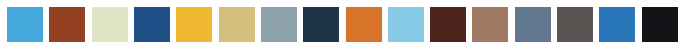

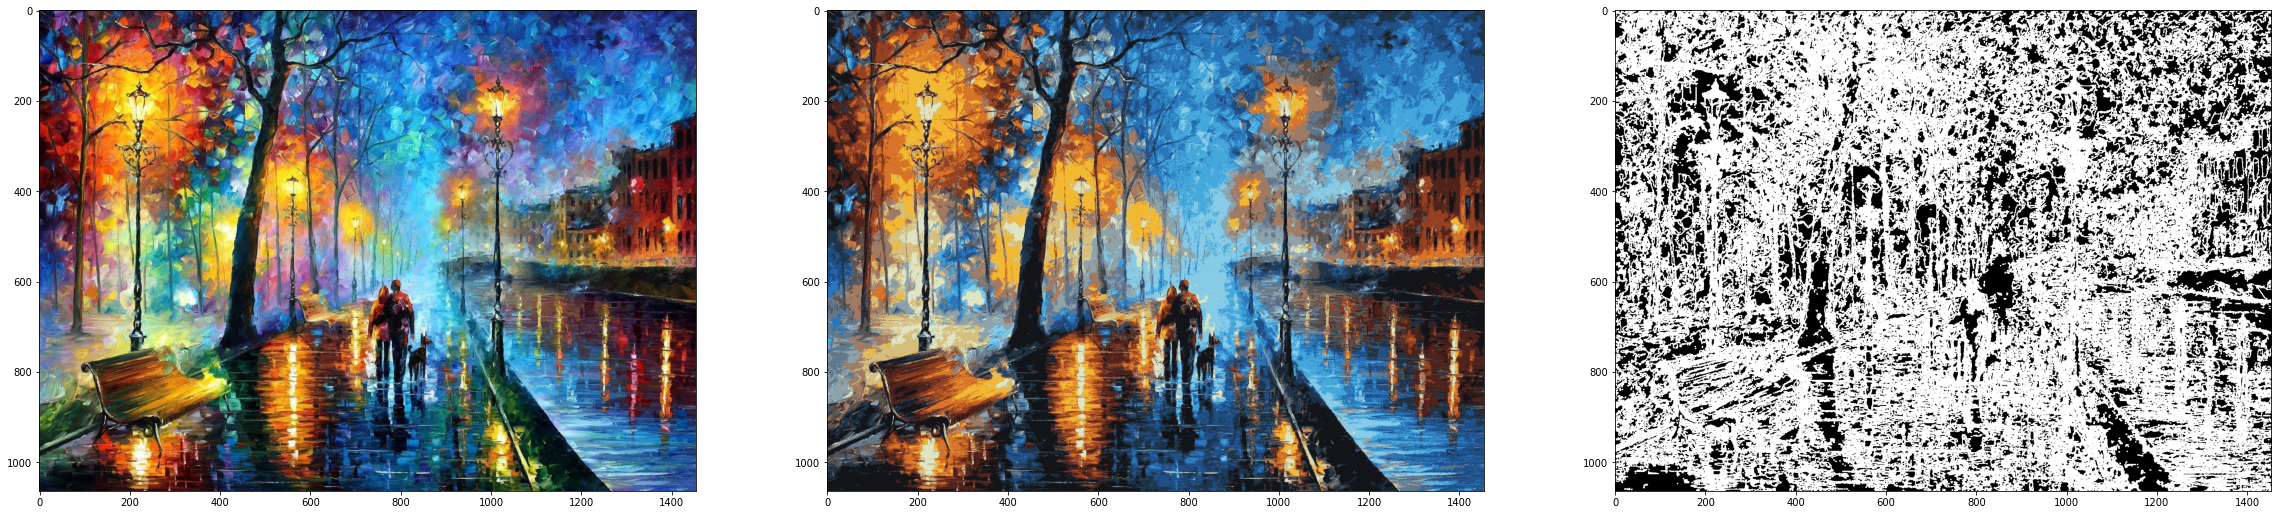

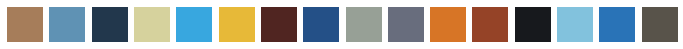

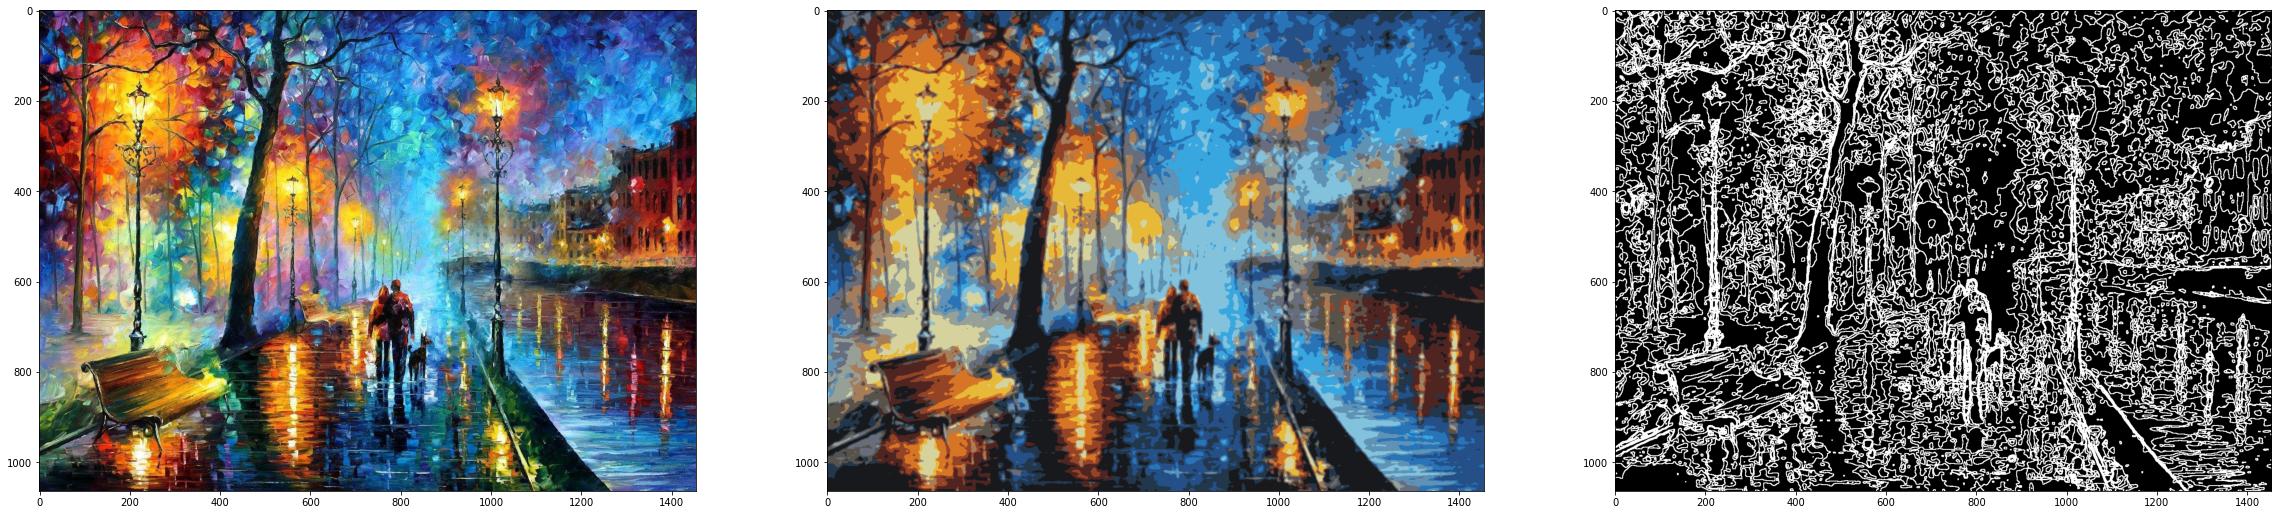

In [8]:
#image_kmean = exploratory_pipeline('../images/raw/painting_afremov.jpg', N=16, palette_shape=(1,16), save_path=None)

In [ ]:
image_flood_fill(a)